In [1]:
import json

with open('data.json') as fp:
    data = json.load(fp)

data[:5]  # Close value every 30 minutes

[7.8e-07, 7.8e-07, 7.7e-07, 7.7e-07, 7.8e-07]

In [2]:
import math

group_length = 10
normalised_group_length = 4
groups = []

def normalise(group):
    reduced = [group[0], group[5], *group[7:]]
    mi, ma = (min(reduced), max(reduced))
    if mi == ma:
        return [0] * len(reduced)
    return [
        (val - mi) * (1 / (ma - mi))
        for val in reduced
    ]

for group in range(len(data) - group_length):
    groups.append(normalise(data[group:group + group_length]))

xs = [g[0:normalised_group_length] for g in groups]
ys = [g[normalised_group_length] for g in groups]

print('groups', xs[:5])
print('labels', ys[:5])

groups [[1.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.5, 1.0], [0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0], [1.0, 1.0, 0.0, 1.0]]
labels [1.0, 1.0, 0.0, 1.0, 0.0]


In [3]:
from sklearn.model_selection import train_test_split as tts

train_x, test_x, train_y, test_y = tts(xs, ys, test_size=100)

In [4]:
def score(title, predict_fn):
    correct, wrong, error = 0, 0, 0

    for x, y in zip(test_x, test_y):
        prediction = predict_fn(np.array([x]))[0] < x[-1]
        actual = y < x[-1]

        error += abs(predict_fn(np.array([x]))[0] - y) ** 2
        correct += actual == prediction
        wrong += actual != prediction

    error /= len(test_x)

    print(title + ':')
    print('correct', int(correct), 'wrong', int(wrong), 'percentage', float(correct/len(test_x)) * 100, 'mse', float(error))

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

model = Sequential([
    Dense(normalised_group_length, input_shape=(normalised_group_length,)),
    Dense(1),
])

model.compile(optimizer='sgd', loss='mse')

import numpy as np
model.fit(
    x=np.array(train_x),
    y=np.array(train_y),
    epochs=1
)

score('neural net score', model.predict)

Using TensorFlow backend.


Epoch 1/1
36104/36104 [==============================] - 1s 26us/step - loss: 0.2515
neural net score:
correct 67 wrong 33 percentage 67.0 mse 0.19448302686214447


In [6]:
from sklearn.svm import SVR

classifier = SVR(max_iter=2000)
classifier.fit(np.array(train_x), np.array(train_y))

score('SVR score', classifier.predict)

SVR score:
correct 74 wrong 26 percentage 74.0 mse 0.2092514315924983


/home/fabio/devel/digits/venv/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [7]:
from sklearn.ensemble import RandomForestRegressor

forest_regressor = RandomForestRegressor()
forest_regressor.fit(train_x, train_y)

score('random forest regressor score', forest_regressor.predict)

random forest regressor score:
correct 68 wrong 32 percentage 68.0 mse 0.1522853267217109


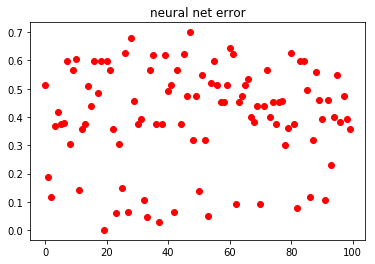

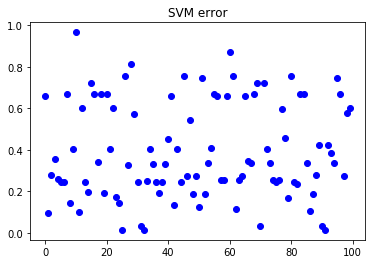

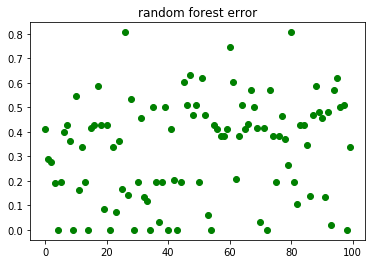

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

neural_error = []
svm_error = []
forest_error = []
for x, y in list(zip(test_x, test_y))[:100]:
    def error(prediction):
        return abs(prediction - y)
    neural_error.append(error(model.predict(np.array([x]))[0]))
    svm_error.append(error(classifier.predict(np.array([x]))[0]))
    forest_error.append(error(forest_regressor.predict(np.array([x]))[0]))

plt.figure(1)
plt.title('neural net error')
plt.plot(range(100), neural_error, 'ro')
plt.figure(2)
plt.title('SVM error')
plt.plot(range(100), svm_error, 'bo')
plt.figure(3)
plt.title('random forest error')
plt.plot(range(100), forest_error, 'go')